In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

demographics = pd.read_excel('/content/drive/MyDrive/demographics.xlsx')
location = pd.read_excel('/content/drive/MyDrive/location.xlsx')
population = pd.read_excel('/content/drive/MyDrive/population.xlsx')
services = pd.read_excel('/content/drive/MyDrive/services.xlsx')
status = pd.read_excel('/content/drive/MyDrive/status.xlsx')


Mounted at /content/drive


In [2]:
for df in [demographics, location, services, status]:
    if "Count" in df.columns:
      df.drop(columns=["Count"], inplace=True)

df = pd.merge(demographics, location, on="Customer ID", how="left")
df = pd.merge(df, services, on="Customer ID", how="left")
df = pd.merge(df, status, on="Customer ID", how="left")

zip_pop_map = population.set_index("Zip Code")["Population"].to_dict()

df["Population"] = df["Zip Code"].map(zip_pop_map)

df.drop(columns=["Lat Long", "Churn Label", "Customer Status",
                 "Quarter_x", "Quarter_y", "Country", "State", "City"], inplace=True)
df.drop(columns=["Churn Category", "Churn Reason"], inplace=True)
df.drop(columns=["Customer ID", "Status ID", "Location ID", "Service ID"], inplace=True)

In [3]:
binary_cols = ["Gender","Senior Citizen","Married","Dependents","Phone Service","Internet Service",
               "Multiple Lines","Online Security","Online Backup","Device Protection Plan",
               "Premium Tech Support","Streaming TV","Streaming Movies","Streaming Music",
               "Unlimited Data","Paperless Billing","Under 30","Referred a Friend"]

for col in binary_cols:
    df[col] = df[col].map({"Yes":1, "No":0, "Male":1, "Female":0})

categorical_cols = df.select_dtypes(include="object").columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 48 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             7043 non-null   int64  
 1   Age                                7043 non-null   int64  
 2   Under 30                           7043 non-null   int64  
 3   Senior Citizen                     7043 non-null   int64  
 4   Married                            7043 non-null   int64  
 5   Dependents                         7043 non-null   int64  
 6   Number of Dependents               7043 non-null   int64  
 7   Zip Code                           7043 non-null   int64  
 8   Latitude                           7043 non-null   float64
 9   Longitude                          7043 non-null   float64
 10  Referred a Friend                  7043 non-null   int64  
 11  Number of Referrals                7043 non-null   int64

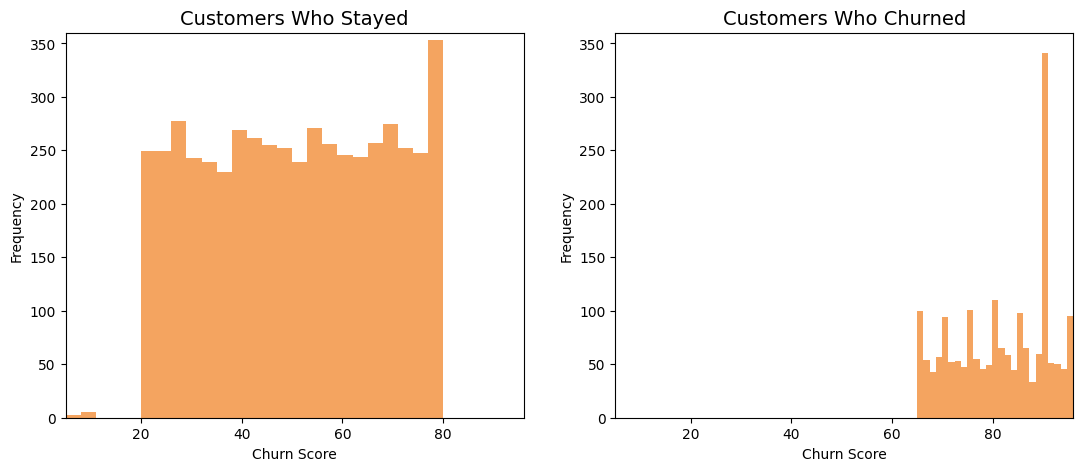

In [8]:
min_score = min(df["Churn Score"])
max_score = max(df["Churn Score"])

fig, ax = plt.subplots(1,2, figsize=(13,5))
for i, churn in enumerate([0,1]):
    ax[i].hist(df[df["Churn Value"]==churn]["Churn Score"], bins=25, color='sandybrown')
    ax[i].set_xlabel("Churn Score")
    ax[i].set_ylabel("Frequency")
    ax[i].set_xlim(min_score, max_score)
    ax[i].set_ylim(0,360)

for i, churn in enumerate([0,1]):
  if churn == 0:
    ax[i].set_title(f"Customers Who Stayed", fontsize=14)
  if churn == 1:
    ax[i].set_title(f"Customers Who Churned", fontsize=14)

plt.show()

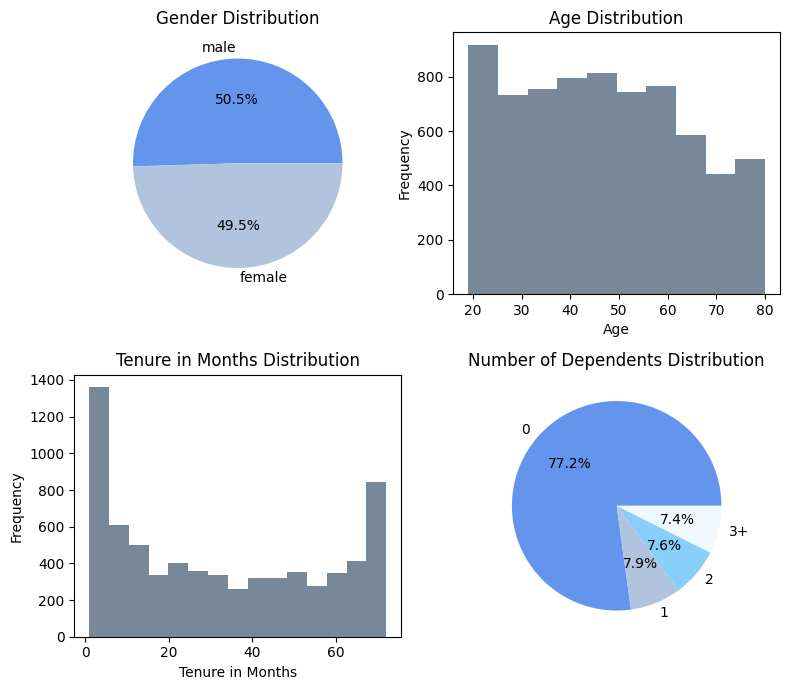

In [51]:
fig, ax = plt.subplots(2,2, figsize=(8,7))
gender = ["male", "female"]
ax[0,0].pie(df["Gender"].value_counts(), labels=gender, autopct='%1.1f%%', colors=["cornflowerblue", "lightsteelblue"])
ax[0,0].set_title("Gender Distribution")

ax[0,1].hist(df["Age"], bins=10, color='lightslategrey')
ax[0,1].set_xlabel("Age")
ax[0,1].set_ylabel("Frequency")
ax[0,1].set_title("Age Distribution")

dependents = pd.DataFrame()
for i in range(4):
  dependents = pd.concat([dependents, df[df["Number of Dependents"]==i]])

ax[1,1].pie(dependents["Number of Dependents"].value_counts(), labels=["0", "1", "2", "3+"], autopct='%1.1f%%', colors=["cornflowerblue", "lightsteelblue", "lightskyblue", "aliceblue"])
ax[1,1].set_title("Number of Dependents Distribution")

ax[1,0].hist(df["Tenure in Months"], bins=15, color='lightslategrey')
ax[1,0].set_xlabel("Tenure in Months")
ax[1,0].set_ylabel("Frequency")
ax[1,0].set_title("Tenure in Months Distribution")

plt.tight_layout()
plt.show()

In [52]:
from sklearn.model_selection import train_test_split

y = df["Churn Value"]
X = df.drop(columns=["Churn Value", "Churn Score"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

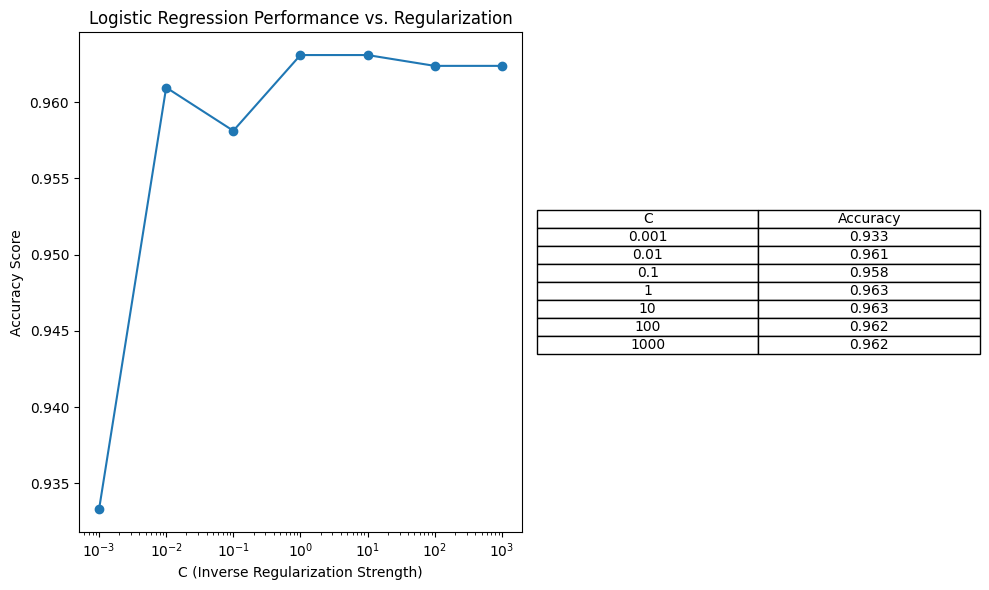

In [53]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

transformer = Pipeline(steps=[("scaler", StandardScaler())])
preprocessor = ColumnTransformer(transformers=[("num", transformer, X.columns)])

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

C_value = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
scores = []

for c in C_value:
    logreg_pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(
            C=c, penalty="l2", solver="liblinear", max_iter=1000))])

    logreg_pipeline.fit(X_train, y_train)

    y_pred = logreg_pipeline.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].plot(C_value, scores, marker="o")
ax[0].set_xscale("log")
ax[0].set_xlabel("C (Inverse Regularization Strength)")
ax[0].set_ylabel("Accuracy Score")
ax[0].set_title("Logistic Regression Performance vs. Regularization")

ax[1].table(cellText=[[c, round(score, 3)] for c, score in zip(C_value, scores)],
            colLabels=["C", "Accuracy"], loc="center", cellLoc="center")
ax[1].axis("off")

plt.tight_layout()
plt.show()

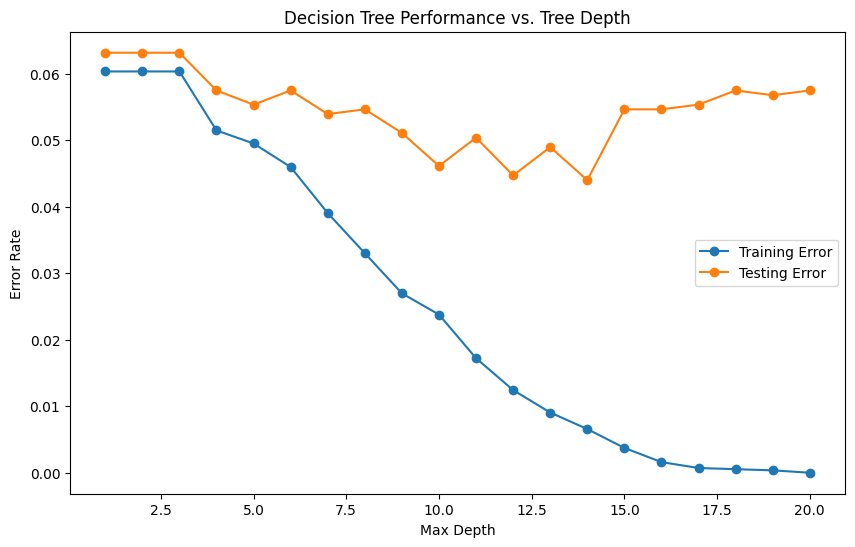

In [54]:
from sklearn.tree import DecisionTreeClassifier

train_errors = []
test_errors = []
depths = range(1, 21)

for d in depths:
    dt = DecisionTreeClassifier(max_depth=d, criterion="gini", random_state=42)
    dt.fit(X_train, y_train)

    y_train_pred = dt.predict(X_train)
    y_test_pred = dt.predict(X_test)

    train_errors.append(1 - accuracy_score(y_train, y_train_pred))
    test_errors.append(1 - accuracy_score(y_test, y_test_pred))

plt.figure(figsize=(10,6))
plt.plot(depths, train_errors, marker="o", label="Training Error")
plt.plot(depths, test_errors, marker="o", label="Testing Error")
plt.xlabel("Max Depth")
plt.ylabel("Error Rate")
plt.title("Decision Tree Performance vs. Tree Depth")
plt.legend(loc="right")
plt.show()


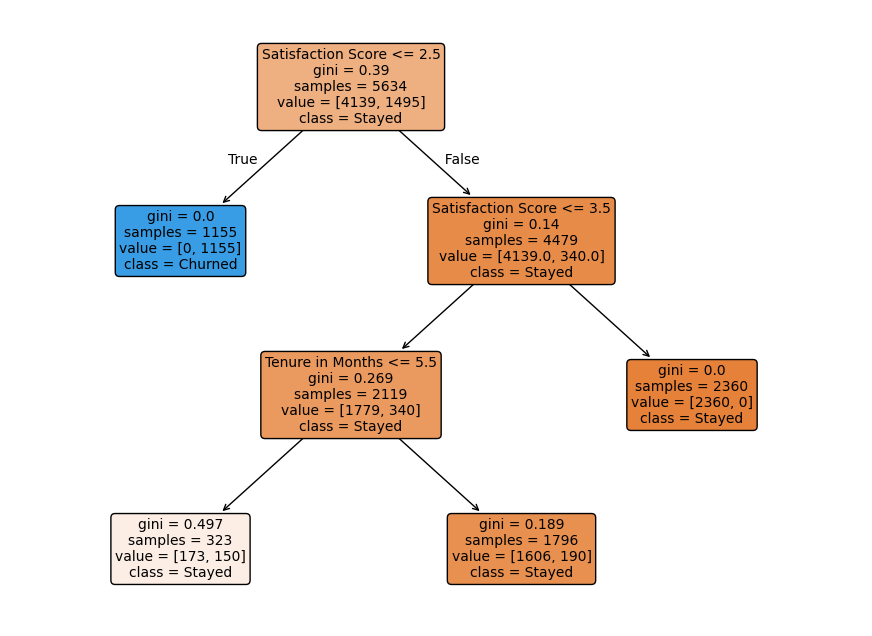

In [10]:
from sklearn.tree import plot_tree

dt = DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=42)
dt.fit(X_train, y_train)

plt.figure(figsize=(11,8))
plot_tree(dt, feature_names=X.columns, class_names=["Stayed", "Churned"],
    filled=True, rounded=True, fontsize=10)

plt.show()

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
ab = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

ensemble_models = {"Random Forest": rf, "Gradient Boosting": gb, "AdaBoost": ab }

scores = {}
for name, model in ensemble_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores[name] = accuracy_score(y_test, y_pred)

for name, score in scores.items():
    print(f"{name}: Accuracy = {score:.3f}")

Random Forest: Accuracy = 0.956
Gradient Boosting: Accuracy = 0.960
AdaBoost: Accuracy = 0.937


Text(0.5, 1.0, 'Performance vs. n_estimators for Random Forest')

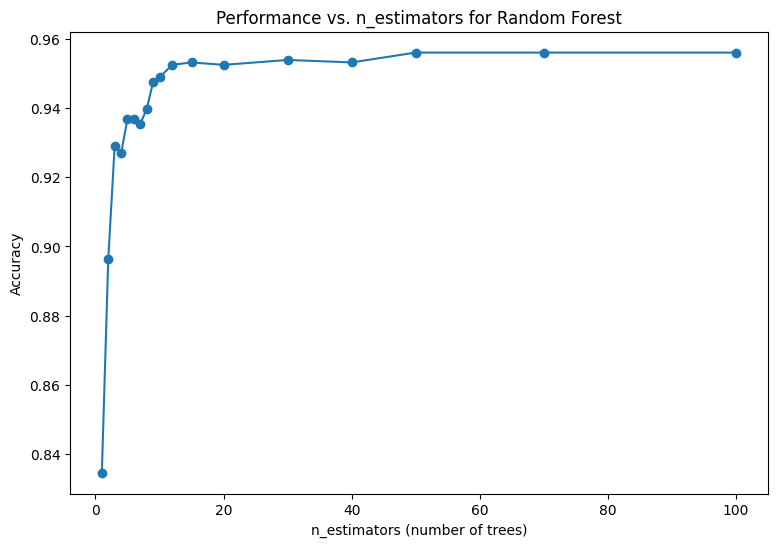

In [ ]:
n_estimators_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 30, 40, 50, 70, 100]
rf_scores = []

for n in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    rf_scores.append(accuracy_score(y_test, rf.predict(X_test)))

plt.figure(figsize=(9,6))
plt.plot(n_estimators_range, rf_scores, marker="o")
plt.xlabel("n_estimators (number of trees)")
plt.ylabel("Accuracy")
plt.title("Performance vs. n_estimators for Random Forest")

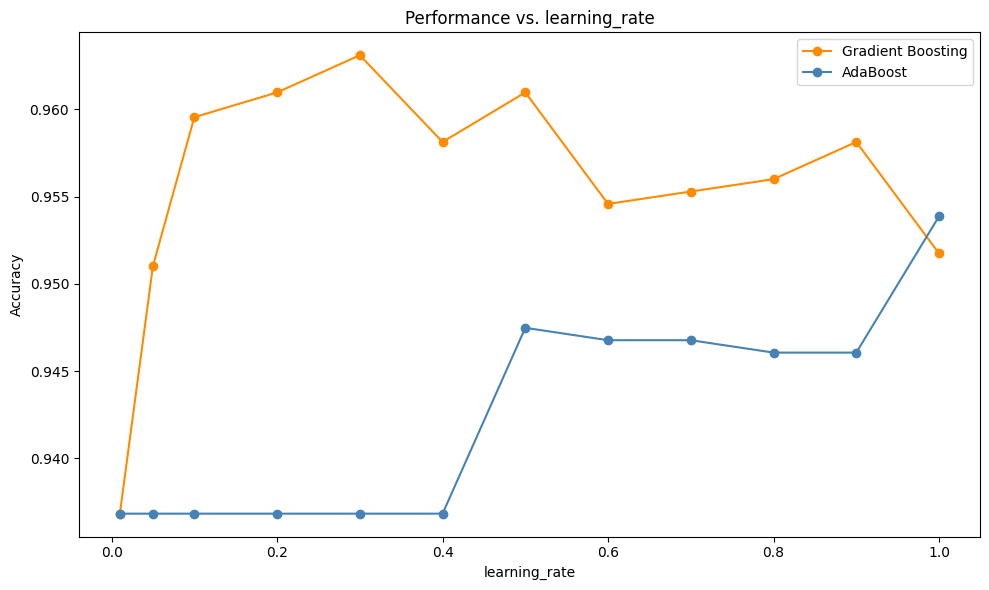

In [12]:
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

gb_scores, ab_scores = [], []

for lr in learning_rates:
    gb = GradientBoostingClassifier(learning_rate=lr, random_state=42)
    gb.fit(X_train, y_train)
    gb_scores.append(accuracy_score(y_test, gb.predict(X_test)))

    ab = AdaBoostClassifier(learning_rate=lr, random_state=42)
    ab.fit(X_train, y_train)
    ab_scores.append(accuracy_score(y_test, ab.predict(X_test)))

plt.figure(figsize=(10,6))

plt.plot(learning_rates, gb_scores, marker="o", color="darkorange", label="Gradient Boosting")
plt.plot(learning_rates, ab_scores, marker="o", color="steelblue", label="AdaBoost")
plt.xlabel("learning_rate")
plt.ylabel("Accuracy")
plt.title("Performance vs. learning_rate")
plt.legend()

plt.tight_layout()
plt.show()

In [56]:
#Finalized models
from sklearn.metrics import (f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc)

#Logistic Regression
transformer = Pipeline(steps=[("scaler", StandardScaler())])
preprocessor = ColumnTransformer(transformers=[("num", transformer, X.columns)])
logreg_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(C=5, penalty="l2", solver="liblinear", max_iter=1000))])
logreg_pipeline.fit(X_train, y_train)
logreg_y_pred = logreg_pipeline.predict(X_test)
logreg_f1score = f1_score(y_test, logreg_y_pred)
logreg_accscore = accuracy_score(y_test, logreg_y_pred)

#Decision Tree
dt = DecisionTreeClassifier(max_depth=5, criterion="gini", random_state=42)
dt.fit(X_train, y_train)
y_test_pred_dt = dt.predict(X_test)
dt_f1score = f1_score(y_test, y_test_pred_dt)
dt_accscore = accuracy_score(y_test, y_test_pred_dt)

#Random Forest
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)
y_test_pred_rf = rf.predict(X_test)
rf_f1score = f1_score(y_test, y_test_pred_rf)
rf_accscore = accuracy_score(y_test, y_test_pred_rf)

#Gradient Boosting
gb = GradientBoostingClassifier(learning_rate=0.3, random_state=42)
gb.fit(X_train, y_train)
y_test_pred_gb = gb.predict(X_test)
gb_f1score = f1_score(y_test, y_test_pred_gb)
gb_accscore = accuracy_score(y_test, y_test_pred_gb)

#AdaBoost
ab = AdaBoostClassifier(learning_rate=1.0, random_state=42)
ab.fit(X_train, y_train)
y_test_pred_ab = ab.predict(X_test)
ab_f1score = f1_score(y_test, y_test_pred_ab)
ab_accscore = accuracy_score(y_test, y_test_pred_ab)

#Performance metrics
f1_scores = [logreg_f1score, dt_f1score, rf_f1score, gb_f1score, ab_f1score]
accuracy_scores = [logreg_accscore, dt_accscore, rf_accscore, gb_accscore, ab_accscore]

print("Logistic Regression: ", "F1: ", f1_scores[0], "Accuracy: ", accuracy_scores[0], "\n")
print("Decision Tree: ",  "F1: ", f1_scores[1], "Accuracy: ", accuracy_scores[1], "\n")
print("Random Forest: ",  "F1: ", f1_scores[2], "Accuracy: ", accuracy_scores[2], "\n")
print("Gradient Boost: ",  "F1: ", f1_scores[3], "Accuracy: ", accuracy_scores[3], "\n")
print("AdaBoost: ",  "F1: ", f1_scores[4], "Accuracy: ", accuracy_scores[4], "\n")

Logistic Regression:  F1:  0.9285714285714286 Accuracy:  0.9630943931866572 

Decision Tree:  F1:  0.8866279069767442 Accuracy:  0.9446415897799858 

Random Forest:  F1:  0.9111747851002865 Accuracy:  0.9559971611071683 

Gradient Boost:  F1:  0.9279778393351801 Accuracy:  0.9630943931866572 

AdaBoost:  F1:  0.908835904628331 Accuracy:  0.9538679914833215 



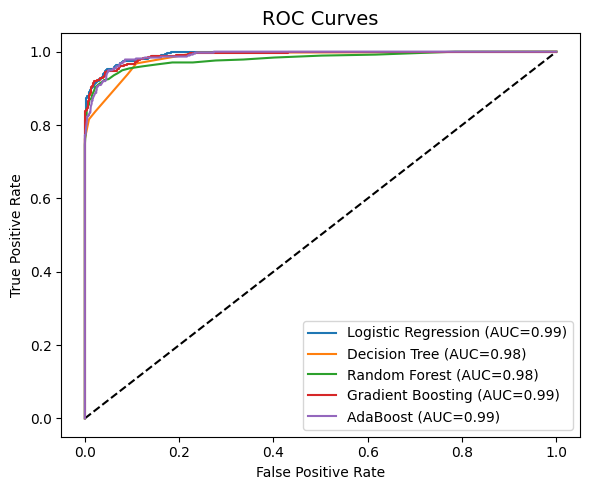

In [27]:
plt.figure(figsize=(6,5))
plt.plot([0,1],[0,1],"k--")
plt.title("ROC Curves", fontsize=14)

models = ["Logistic Regression", "Decision Tree", "Random Forest", "Gradient Boosting", "AdaBoost"]
for i, model in enumerate([logreg_pipeline, dt, rf, gb, ab]):
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{models[i]} (AUC={roc_auc_score(y_test,y_prob):.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()

plt.show()

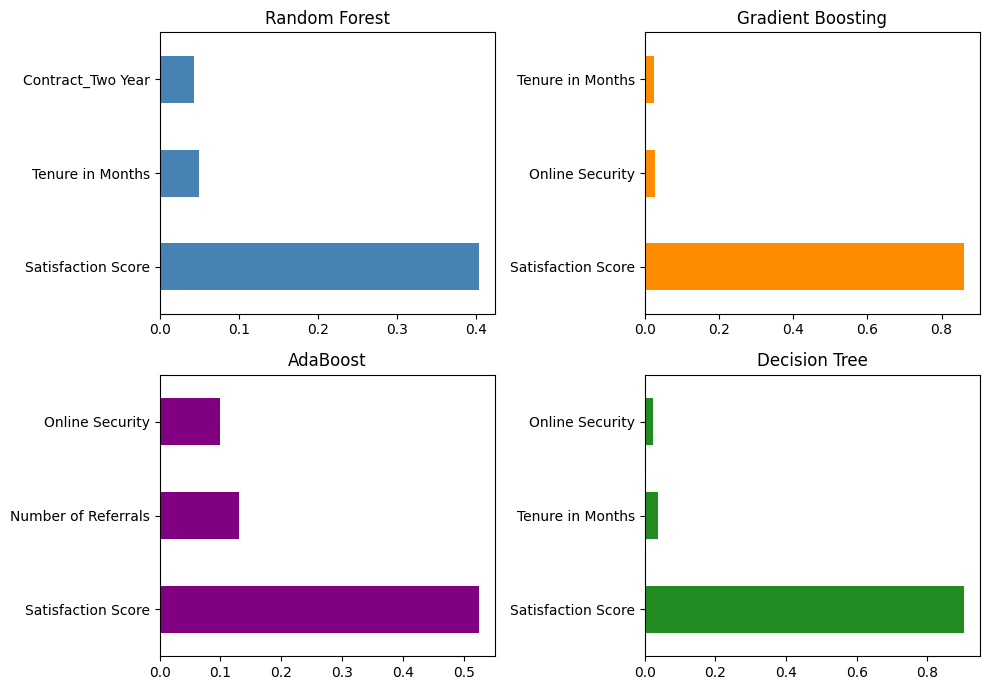

In [85]:
rf_importance = rf.feature_importances_
gb_importance = gb.feature_importances_
ab_importance = ab.feature_importances_
dt_importance = dt.feature_importances_

fig, ax = plt.subplots(2, 2, figsize=(10,7))

pd.Series(rf_importance, index=X.columns).sort_values(ascending=False).head(3).plot(
    kind="barh", ax=ax[0,0], color="steelblue")
ax[0,0].set_title("Random Forest")

pd.Series(gb_importance, index=X.columns).sort_values(ascending=False).head(3).plot(
    kind="barh", ax=ax[0,1], color="darkorange")
ax[0,1].set_title("Gradient Boosting")

pd.Series(ab_importance, index=X.columns).sort_values(ascending=False).head(3).plot(
    kind="barh", ax=ax[1,0], color="purple")
ax[1,0].set_title("AdaBoost")

pd.Series(dt_importance, index=X.columns).sort_values(ascending=False).head(3).plot(
    kind="barh", ax=ax[1,1], color="forestgreen")
ax[1,1].set_title("Decision Tree")

plt.tight_layout()
plt.show()

In [90]:
spss_pred = (df["Churn Score"] >= 80).astype(int)
spss_accscore = accuracy_score(y, spss_pred)
print("Logistic Regression Accuracy:", logreg_accscore)
print("SPSS Predictor Accuracy:", spss_accscore)

Logistic Regression Accuracy: 0.9630943931866572
SPSS Predictor Accuracy: 0.8797387476927445
